In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import time
import math

import h5py

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

%matplotlib inline

# RBM theory
-From paper: https://iopscience.iop.org/article/10.1088/1478-3975/aa5ce6/pdf

-Modified from code: https://github.com/aexbrown/Crawl_Model/tree/master/src and applied to Monika's data for test

In [4]:
filename = '/Users/Macintosh/Downloads/AML32_moving.hdf5'
f = h5py.File(filename, 'r')

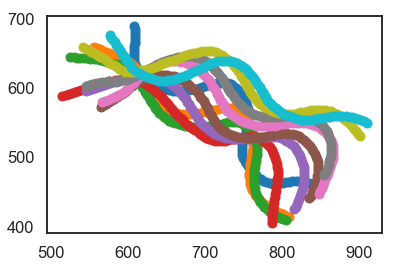

In [42]:
cls = f['BrainScanner20170424_105620']['CL']#['Behavior']['Eigenworm1']
for tt in range(0,10):
    temp = cls[tt]
    plt.plot(temp[:,0],temp[:,1],'-o')

In [339]:
#prep for posture data
window = np.arange(500,1000)
T = len(window)  #time window
cll = cls[0].shape[0]  #length of the center-line
X = np.zeros((T,cll))
Y = np.zeros((T,cll))
for ii,tt in enumerate(window):
    X[ii,:] = cls[tt][:,0]
    Y[ii,:] = cls[tt][:,1]
dt = 1

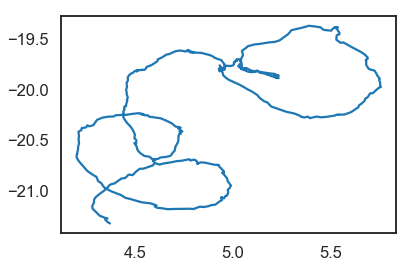

In [340]:
#true trajectory data
x_true = f['BrainScanner20170424_105620']['Behavior']['X']
y_true = f['BrainScanner20170424_105620']['Behavior']['Y']
plt.plot([x_true[ww] for ww in window],[y_true[ww] for ww in window])

In [308]:
def post2RBM(TX, TY, DX, DY, VX, VY, L, I, ds, alpha):
    """
    Build up rigid-body-model from the posture variables, by solving the linear dynamial euqations
    """
    # initialise
    RBM = np.zeros((TX.shape[0]-1,3))  #time x 3 (for x-y motion and angle)

    # get tangential component of velocity at each skeleton point without
    # centre of mass (the wiggles)
    TdotV = TX[1:,:]*VX + TY[1:,:]*VY;

    # get cross product of relative skeleton position with tangent
    DelXcrossT = DX[1:,:]*TY[1:,:] - DY[1:,:]*TX[1:,:]

    for ii in range(0,RBM.shape[0]-1):
        # assemble right hand side
        
        b1 = (alpha - 1)*ds*np.trapz(TX[ii+1,:]*TdotV[ii,:]);
        b2 = (alpha - 1)*ds*np.trapz(TY[ii+1,:]*TdotV[ii,:]);
        b3 = (alpha - 1)*ds*np.trapz(DelXcrossT[ii,:]*TdotV[ii,:])

        # the matrix relating rigid body motion to the wiggles
        A11 = alpha*L + (1 - alpha)*ds*np.trapz(TX[ii+1,:]**2)
        A12 = (1 - alpha)*ds*np.trapz(TX[ii+1,:]*TY[ii+1,:])
        A13 = (1 - alpha)*ds*np.trapz(TX[ii+1,:]*DelXcrossT[ii,:])

        A22 = alpha*L + (1 - alpha)*ds*np.trapz(TY[ii+1,:]**2)
        A21 = A12;
        A23 = (1 - alpha)*ds*np.trapz(TY[ii+1,:]*DelXcrossT[ii,:])

        A31 = A13
        A32 = A23
        A33 = alpha*I[ii+1] + (1 - alpha)*ds*np.trapz(DelXcrossT[ii,:]**2)

        # solve the linear system
        bvec = np.array([b1, b2, b3])
        Amat = np.array([[A11, A12, A13],[A21, A22, A23], [A31, A32, A33]])
        RBM[ii,:] = np.linalg.solve(Amat,bvec)

    return RBM


In [205]:
def RBM2traj(RBM,dt):
    """
    Reconstruct CM trajectories from RBM matrix
    """
    Ntcm = RBM.shape[0]

    #Center of mass position as a function of time
    XCM = np.zeros((Ntcm,1))
    YCM = np.zeros((Ntcm,1))

    #integrating RBM
    for ii in range(1,Ntcm):  
        itm1 = ii - 1;
        XCM[ii] = XCM[itm1] + dt*RBM[itm1,0]
        YCM[ii] = YCM[itm1] + dt*RBM[itm1,1]
    return XCM, YCM

In [293]:
def TvecFromSkel(X,Y,L,ds):
    """
    get tangential vectors from the posture 
    """
    Ns, Nf = X.shape[0], X.shape[1]
    TX = np.zeros((Ns,Nf))
    TY = np.zeros((Ns,Nf))
    
    for n in range(0,Ns-1):
        if n==1:  #initial step
            TX[n,:] = X[n+1,:]-X[n,:]
            TY[n,:] = Y[n+1,:]-Y[n,:]
        elif n==Ns:  #keep last step
            TX[n,:] = X[n,:]-X[n-1,:]
            TY[n,:] = Y[n,:]-Y[n-1,:]
        else:     #interpolare
            TX[n,:] = 0.5*(X[n+1,:]-X[n-1,:])
            TY[n,:] = 0.5*(Y[n+1,:]-Y[n-1,:])
    
    TX = TX/ds
    TY = TY/ds
    Tmag = np.sqrt(TX**2+TY**2)  #normal vectors
    TX = TX/Tmag
    TY = TY/Tmag
    
    return TX,TY

In [271]:
###rigid body calculations
def get_posture(X,Y,dt,alpha):
    """
    Input x,y time series and dt time steps, with alpha being a free parameter for draf coefficient ratio
    Output all posture measurements needed for RBM formulation
    """
    #ds for arclength increment (assumes constant arclength increment and total length 1)
    ds = 1/(X.shape[1]-1)
    
    #L assuming the length is constant
    L = 1
    
    #Center of mass position
    XCM = ds*np.trapz(X,axis=1)/L
    YCM = ds*np.trapz(Y,axis=1)/L

    #Velocity of the centerline from the data
    UX = (X[1:,:] - X[:-1,:])/dt;
    UY = (Y[1:,:] - Y[:-1,:])/dt;

    #Velocity of the center of mass from the data
    UXCM = ds*np.trapz(UX,axis=1)/L
    UYCM = ds*np.trapz(UY,axis=1)/L

    #unit vector tangent to the worm
    TX,TY = TvecFromSkel(X.T,Y.T,L,ds)

    TX = -TX.T
    TY = -TY.T
    NX = -TY  #unit vector normal to the worm!
    NY = TX

    #Computing the angular velocity and moment of inertia from the data
    Iint = np.zeros_like(X)
    Omegint = np.zeros_like(X)

    for ii in range(0,X.shape[0]):
        # get integrand for moment of intertia
        Iint[ii,:] = (X[ii,:] - XCM[ii])**2 + (Y[ii,:] - YCM[ii])**2

        if ii > 0:
            # cross product of dX with U (for angular velocity)
            itm1 = ii - 1
            Omegint[itm1,:] = (X[ii,:] - XCM[ii])*(UY[itm1,:]-UYCM[itm1]) - \
            (Y[ii,:] - YCM[ii])*(UX[itm1,:]-UXCM[itm1])

    I = ds*np.trapz(Iint,axis=1) #moment of inertia
    OMEG = ds*np.trapz(Omegint,axis=1)/I  #angular velocity
    OMEG = OMEG[:-1]
    
    
    ##### subtraction #####
    # initialise
    DX = np.zeros_like(X)
    DY = np.zeros_like(X)
    ODX = np.zeros((X.shape[0]-1,X.shape[1]))
    ODY = np.zeros((X.shape[0]-1,X.shape[1]))

    Xtil = np.zeros_like(X)
    Ytil = np.zeros_like(X)
    THETA = np.zeros((X.shape[0],1))
    THETA[0] = 0

    #Subtracting the rigid body motion (RBM) from the data
    for ii in range(0,X.shape[0]):
        DX[ii,:] = X[ii,:] - XCM[ii]
        DY[ii,:] = Y[ii,:] - YCM[ii]
        Xtil[ii,:] = DX[ii,:]
        Ytil[ii,:] = DY[ii,:]

        if ii>0:
            #cross product of dX with U (for angular velocity)
            itm1 = ii-1

            ODX[itm1,:] = OMEG[itm1]*DX[ii,:]
            ODY[itm1,:] = OMEG[itm1]*DY[ii,:]
            THETA[ii] = THETA[ii-1] + OMEG[itm1]*dt

            Xtil[ii,:] = np.cos(THETA[ii])*DX[ii,:] + np.sin(THETA[ii])*DY[ii,:]
            Ytil[ii,:] = np.cos(THETA[ii])*DY[ii,:] - np.sin(THETA[ii])*DX[ii,:]

    VX = UX - np.repeat(UXCM[None,:],X.shape[1],axis=0).T + ODY
    VY = UY - np.repeat(UYCM[None,:],X.shape[1],axis=0).T - ODX
    
    return TX, TY, DX, DY, VX, VY, L, I, ds, alpha

### tangent xy, relative x-y, velocity x-y, length, angular velocity, ds archs, and ratio of coefficients

In [341]:
TX, TY, DX, DY, VX, VY, L, I, ds, alpha = get_posture(X,Y,1,80)
TX[:,-1] = 0
TY[:,-1] = 0
RBM = post2RBM(TX, TY, DX, DY, VX, VY, L, I, 1, alpha)
xx,yy = RBM2traj(RBM,dt)

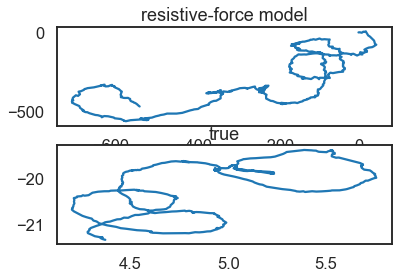

In [349]:
plt.figure()
plt.subplot(211)
plt.title('resistive-force model')
plt.plot(yy,xx)
tempx = [x_true[ww] for ww in window]
tempy = [y_true[ww] for ww in window]
plt.subplot(212)
plt.title('true')
plt.plot(tempx,tempy)

It kind of works! But probably need to scan parameters for the setup (coefficient ratio body length) and correct for phase.